In [47]:
import pandas as pd
import statsmodels.api as sm
import re
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.formula.api import logit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.preprocessing import PolynomialFeatures
from collections import Counter
from imblearn.over_sampling import SMOTE

ModuleNotFoundError: No module named 'sklearn.neighbors.base'

In [2]:
full_dataset = pd.read_csv('archive/Loan_status_2007-2020Q3.gzip')

/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
full_dataset.columns

Index(['Unnamed: 0', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
       'hardship_length', 'hardship_dpd', 'hardship_loan_status',
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag'],
      dtype='object', length=142)

In [4]:
full_dataset['issue_d'] = pd.to_datetime(full_dataset['issue_d'])
mask = (full_dataset['issue_d'] > '2014-01-01') & (full_dataset['issue_d'] <= '2015-01-01')
small_dataset = full_dataset[mask]

In [38]:
columns = ['annual_inc', 'chargeoff_within_12_mths', 'delinq_2yrs', 'dti', 'emp_length', 'emp_title', 'funded_amnt', 
           'home_ownership', 'inq_last_6mths', 'int_rate', 'issue_d', 'loan_amnt',
           'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'term', 'total_acc', 'verification_status', 'loan_status']
df = small_dataset[columns]


In [6]:
df['loan_status'].unique()

array(['Charged Off', 'Fully Paid', 'Current', 'Late (31-120 days)',
       'Default', 'In Grace Period'], dtype=object)

In [7]:
df['purpose'].unique()

array(['credit_card', 'debt_consolidation', 'car', 'house',
       'home_improvement', 'other', 'medical', 'major_purchase', 'moving',
       'vacation', 'small_business', 'renewable_energy', 'wedding'],
      dtype=object)

In [39]:
def clean_data(X):
    X = X.dropna()
    X['emp_length'] = [float(re.sub('[a-zA-Z +<]*', '', str(string))) for string in X['emp_length']]
    X['int_rate'] = [float(re.sub('[a-zA-Z %]*', '', str(string))) for string in X['int_rate']]
    X['term'] = [float(re.sub('[a-zA-Z ]*', '', str(string))) for string in X['term']]
    X['home_ownership'] = (X['home_ownership'] == 'OWN').astype('int')
    X['verification_status'] = (X['verification_status'] != 'Verified') | (X['verification_status'] != 'Source Verified')
    X['verification_status'] = X['verification_status'].astype('int')
    # Remove emp title, issue_d before regression is run, can also try get_dummies for emp_title (Maybe just a few professions or types)
    # Drop funded amount since it is equal to loan amount for our data (Makes matrix singular), all are verified 
    X = X.drop(columns=['emp_title', 'issue_d','funded_amnt', 'verification_status'])
    
    
    #X['loan_status'] = (X['loan_status'] == 'Current') | (X['loan_status'] == 'Fully Paid') | (X['loan_status'] == 'In Grace Period')
    
#     There are so few defaults that instead I think we should do if the loan is paid/current
    mask = (X['loan_status'] == 'Default') | (X['loan_status'] == 'Fully Paid') | (X['loan_status'] == 'Charged Off')
    X = X[mask]
    X['loan_status'] = (X['loan_status'] == 'Default') | (X['loan_status'] == 'Charged Off')
    X['loan_status'] = X['loan_status'].astype('int')
    
    
    
    #Just select the categorical variables
    cat_vars = ['purpose']

    #Create dummy variables for each cat. variable
    for var in cat_vars:
        cat_list = pd.get_dummies(X[var], prefix=var)
        # Categorical variables that have low count are making matrix singular
        for col in cat_list.columns:
            if sum(cat_list[col]) <= 50:
                cat_list = cat_list.drop(columns=[col])
        X=X.join(cat_list)
        
        

    X = X.drop(columns = cat_vars)
    
    return X
  


In [40]:
# Wrote own function to preserve column names
def normalize(X):
    return (X-X.min())/(X.max()-X.min())

In [41]:
df = clean_data(df[:100000])

/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on 

In [462]:
df

,annual_inc,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,home_ownership,inq_last_6mths,installment,int_rate,loan_amnt,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation
1485415,58000.0,0.0,0.0,14.92,8.0,0,2.0,321.08,6.99,10400.0,...,0,0,0,0,0,0,0,0,0,0
1485416,78000.0,0.0,0.0,12.03,10.0,0,0.0,336.64,12.39,15000.0,...,1,0,0,0,0,0,0,0,0,0
1485417,69000.0,0.0,0.0,25.81,10.0,0,0.0,326.53,13.66,9600.0,...,1,0,0,0,0,0,0,0,0,0
1485418,125000.0,0.0,1.0,8.31,10.0,0,0.0,319.08,17.14,12800.0,...,0,0,0,0,0,0,0,0,0,0
1485419,63800.0,0.0,0.0,18.49,6.0,0,0.0,516.36,15.59,21425.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585410,73000.0,0.0,0.0,16.95,7.0,0,0.0,626.90,15.61,26000.0,...,1,0,0,0,0,0,0,0,0,0
1585411,48000.0,0.0,0.0,12.25,10.0,0,0.0,261.64,14.99,11000.0,...,0,0,0,0,0,0,0,0,0,0
1585412,96000.0,0.0,0.0,9.74,2.0,0,0.0,694.20,11.67,21000.0,...,0,0,0,0,0,0,0,0,0,0
1585413,85000.0,0.0,0.0,20.40,1.0,0,0.0,274.97,10.99,8400.0,...,0,0,0,0,0,0,1,0,0,0


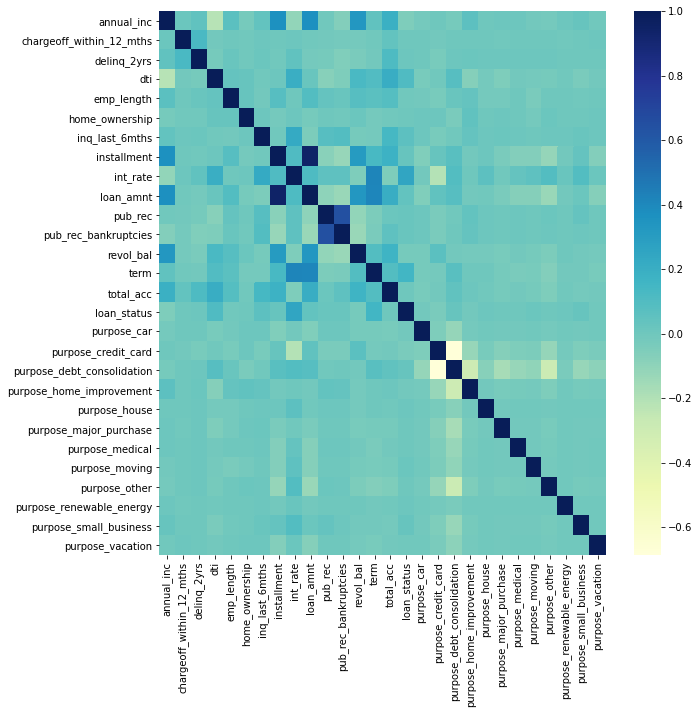

In [37]:
fig, ax = plt.subplots(figsize=(10,10)) 
corrMatrix = df.corr()
sn.heatmap(corrMatrix, cmap="YlGnBu", xticklabels=True, yticklabels=True)
plt.show()

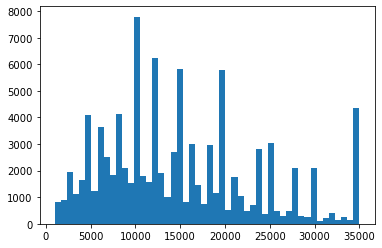

In [64]:
plt.hist(df['loan_amnt'], bins=50)
plt.show()

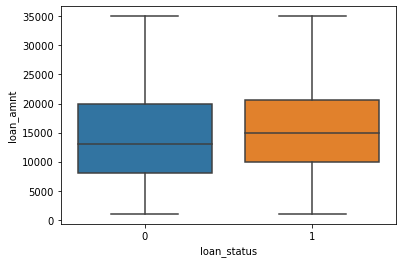

In [465]:
ax = sn.boxplot(y=df['loan_amnt'], x=df['loan_status'])

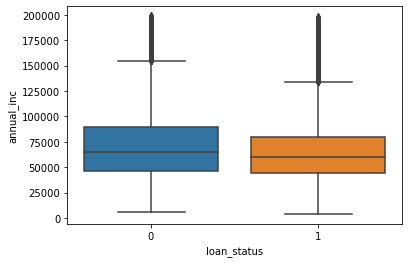

In [466]:
boxplot_df = df[df['annual_inc'] < 2*10**5] 
ax = sn.boxplot(y=boxplot_df['annual_inc'], x=boxplot_df['loan_status'])

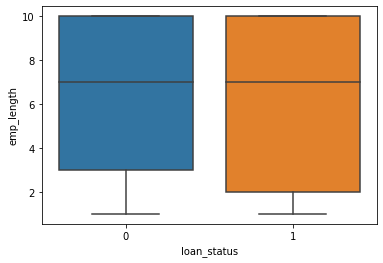

In [467]:
ax = sn.boxplot(y=df['emp_length'], x=df['loan_status'])

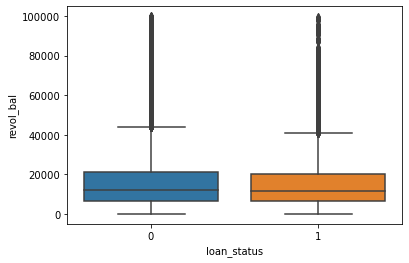

In [34]:
boxplot_df = df[df['revol_bal'] < 1*10**5] 
ax = sn.boxplot(y=boxplot_df['revol_bal'], x=boxplot_df['loan_status'])

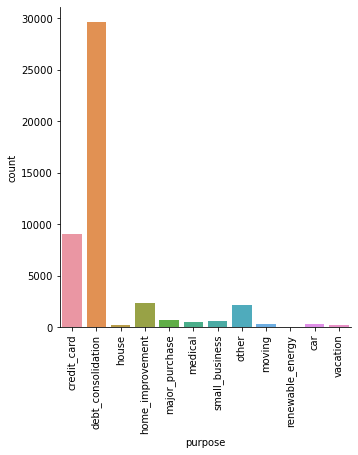

In [468]:
ax = sn.catplot(x="purpose", kind="count", data=small_dataset[(small_dataset["loan_status"] == "Charged Off") | (small_dataset["loan_status"] == "Default")])
ax.set_xticklabels(rotation=90)

In [41]:
df.describe()

,annual_inc,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,home_ownership,inq_last_6mths,installment,int_rate,loan_amnt,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation
count,9.469000e+04,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000,...,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000
mean,7.606553e+04,0.010212,0.347745,18.687679,6.148474,0.098363,0.622537,441.369827,13.257025,15053.951051,...,0.620541,0.050713,0.003337,0.016697,0.009505,0.006400,0.047101,0.000708,0.008977,0.004721
std,5.886480e+04,0.110832,0.911898,8.500398,3.549330,0.297807,0.915039,244.765605,4.391573,8518.500573,...,0.485255,0.219412,0.057672,0.128133,0.097028,0.079743,0.211856,0.026591,0.094320,0.068545
min,4.000000e+03,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,30.420000,6.000000,1000.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.600000e+04,0.000000,0.000000,12.270000,3.000000,0.000000,0.000000,264.460000,10.150000,8400.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.500000e+04,0.000000,0.000000,18.120000,7.000000,0.000000,0.000000,384.340000,12.990000,13512.500000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000e+04,0.000000,0.000000,24.630000,10.000000,0.000000,1.000000,578.420000,15.610000,20000.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.500000e+06,4.000000,22.000000,39.990000,10.000000,1.000000,6.000000,1408.130000,26.060000,35000.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
train, test = train_test_split(df, train_size=0.80, random_state=1)
train = train.fillna(0)
test = test.fillna(0)
X = train.drop(columns=['loan_status'])
# Normalize Data (Using min max)
X = normalize(X)
# Note: Could also try multinomial logistic regression since the loan status doesnt necessarily have to be 0 or 1
# Perhaps cluster robust estimator by loan purpose or some other variable
Y = train['loan_status']

In [49]:
X_test = test.drop(columns=['loan_status'])
X_test = normalize(X_test)
y_test = test['loan_status']
w = {0:1, 1:4}
clf = LogisticRegression(class_weight = w,)
result = clf.fit(X,Y)
y_pred = clf.predict(X_test)


print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')


Accuracy Score: 0.7229087452471483
Confusion Matrix: 
[[12075  3439]
 [ 1808  1614]]
Area Under Curve: 0.6249916272529094
Recall score: 0.4716540035067212


/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [50]:
clf.coef_

array([[-2.7918511 ,  0.33963565,  0.21769831,  0.78244955, -0.08683234,
         0.01887912,  0.29744574,  2.67477414, -0.0355948 ,  1.50502083,
        -6.07724677,  0.3348929 , -0.11114135, -0.36316682,  0.05835468,
         0.01408967, -0.01466195, -0.36363482,  0.1184521 , -0.01840591,
         0.05255761, -0.15990179,  0.38319719,  0.20551671, -0.02636301]])

Logistic: f1=0.381 auc=0.319


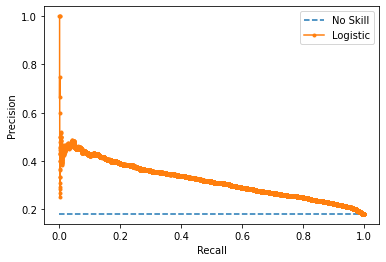

In [51]:
lr_probs = clf.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.620


/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:1323: UserWarning: Elastic net fitting did not converge
  warnings.warn("Elastic net fitting did not converge")


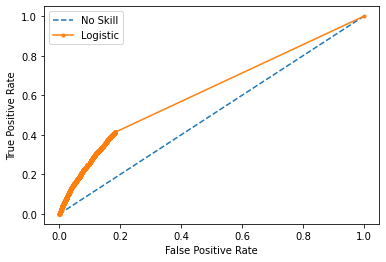

In [52]:
freq = (Y == 1)
freq[Y==1] = 4
freq[Y==0] = 1

clf = GLM(Y,X,family=families.Binomial(),freq_weights = freq)
res = clf.fit_regularized()
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = res.predict(X_test)
lr_probs = lr_probs.reset_index(drop=True)
lr_probs = lr_probs * (lr_probs > .5)
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [53]:
res.params

annual_inc                    -4.446835
chargeoff_within_12_mths       0.306474
delinq_2yrs                    0.146122
dti                            0.803374
emp_length                    -0.075581
home_ownership                 0.021869
inq_last_6mths                 0.297078
int_rate                       2.692678
loan_amnt                      0.065571
pub_rec_bankruptcies           1.473251
revol_bal                    -11.202258
term                           0.325531
total_acc                      0.011504
purpose_car                   -2.055300
purpose_credit_card           -1.629303
purpose_debt_consolidation    -1.681848
purpose_home_improvement      -1.708589
purpose_house                 -2.070441
purpose_major_purchase        -1.571593
purpose_medical               -1.700969
purpose_moving                -1.634234
purpose_other                 -1.848597
purpose_renewable_energy      -1.287763
purpose_small_business        -1.487077
purpose_vacation              -1.707753


In [54]:
lr_probs = res.predict(X_test)
lr_probs = lr_probs.reset_index(drop=True)
lr_probs = (lr_probs > .5).astype('int')
accuracy = np.mean(y_test.reset_index(drop=True) == lr_probs)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 74.40%


In [60]:
res.params

annual_inc                    -4.446835
chargeoff_within_12_mths       0.306474
delinq_2yrs                    0.146122
dti                            0.803374
emp_length                    -0.075581
home_ownership                 0.021869
inq_last_6mths                 0.297078
int_rate                       2.692678
loan_amnt                      0.065571
pub_rec_bankruptcies           1.473251
revol_bal                    -11.202258
term                           0.325531
total_acc                      0.011504
purpose_car                   -2.055300
purpose_credit_card           -1.629303
purpose_debt_consolidation    -1.681848
purpose_home_improvement      -1.708589
purpose_house                 -2.070441
purpose_major_purchase        -1.571593
purpose_medical               -1.700969
purpose_moving                -1.634234
purpose_other                 -1.848597
purpose_renewable_energy      -1.287763
purpose_small_business        -1.487077
purpose_vacation              -1.707753


In [55]:
top_coefs = abs(res.params) > 2

In [56]:
top_coefs

annual_inc                     True
chargeoff_within_12_mths      False
delinq_2yrs                   False
dti                           False
emp_length                    False
home_ownership                False
inq_last_6mths                False
int_rate                       True
loan_amnt                     False
pub_rec_bankruptcies          False
revol_bal                      True
term                          False
total_acc                     False
purpose_car                    True
purpose_credit_card           False
purpose_debt_consolidation    False
purpose_home_improvement      False
purpose_house                  True
purpose_major_purchase        False
purpose_medical               False
purpose_moving                False
purpose_other                 False
purpose_renewable_energy      False
purpose_small_business        False
purpose_vacation              False
dtype: bool

In [61]:
tuning_params = 10**np.linspace(5,-5,50)*0.5
coefs = []
for a in tuning_params:
    clf = GLM(Y,X,family=families.Binomial(),freq_weights = freq)
    log_reg = clf.fit_regularized(alpha=a, L1_wt=1)
    coefs.append(log_reg.params[top_coefs])

    
print(np.shape(coefs))


/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:1323: UserWarning: Elastic net fitting did not converge
  warnings.warn("Elastic net fitting did not converge")


(50, 5)


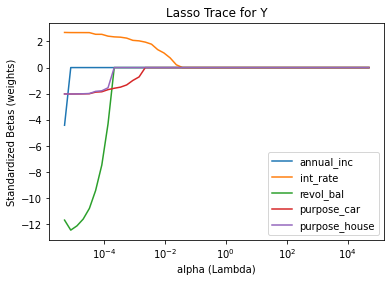

In [62]:
ax = plt.gca()
ax.plot(tuning_params, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.title('Lasso Trace for Y')
plt.xlabel('alpha (Lambda)')
plt.ylabel('Standardized Betas (weights)')
plt.legend(X.columns[top_coefs])

In [24]:
tuning_params = 10**np.linspace(5,-4,50)*0.5
coefs = []
for a in tuning_params:
    clf = GLM(Y,X,family=families.Binomial(),freq_weights = freq)
    log_reg = clf.fit_regularized(alpha=a, L1_wt=0)
    coefs.append(log_reg.params[top_coeffs])

    
print(np.shape(coefs))

(50, 6)


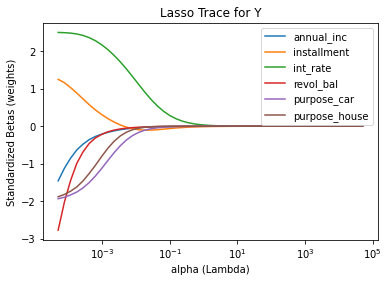

In [25]:
ax = plt.gca()
ax.plot(tuning_params, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.title('Ridge Trace for Y')
plt.xlabel('alpha (Lambda)')
plt.ylabel('Standardized Betas (weights)')
plt.legend(X.columns[top_coefs])

In [ ]:
qda_model = QDA()
qda_model.fit(X,Y)
y_pred = (y_pred > 0.5).astype('int')
y_pred = qda_model.predict(X_test)

print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

In [ ]:
param_grid = {
    'shrinkage': [1.0, 0, 0.1, 0.01, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
    'solver': ['svd', 'lsqr', 'eigen']
}

gs = GridSearchCV(
    LDA(),
    param_grid=param_grid,
    verbose=1,
    cv=5,
    n_jobs=-1
)

lda_gs_results = gs.fit(X, Y)

In [ ]:
print("%-30s %4.10f" % ("LDA Best Score:", lda_gs_results.best_score_))
print("%-30s %4s"    % ("LDA Best Parameters:", lda_gs_results.best_params_))

In [ ]:
lda_model = LDA(shrinkage = 0.001, solver = 'lsqr')
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = lda_model.fit(X,Y)
lr_probs = lda_model.predict_proba(X_test)
lr_probs = lr_probs[:,1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LDA')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
lda_model = LDA(shrinkage = 0.001, solver = 'lsqr')
ns_probs = [0 for _ in range(len(y_test))]
lda_model.fit(X,Y)
lr_probs = lda_model.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
param_grid = {
    'reg_param': [0, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0, 2.0],
    'tol': [0.0001]
}

gs = GridSearchCV(
    QDA(),
    param_grid=param_grid,
    verbose=1,
    cv=5,
    n_jobs=-1
)

qda_gs_results = gs.fit(X, Y)

In [ ]:
print("%-30s %4.10f" % ("QDA Best Score:", qda_gs_results.best_score_))
print("%-30s %4s"    % ("QDA Best Parameters:", qda_gs_results.best_params_))

In [ ]:
qda_model = QDA()
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = qda_model.fit(X,Y)
lr_probs = qda_model.predict_proba(X_test)
lr_probs = lr_probs[:,1]
lr_probs = lr_probs*(lr_probs>0.5)
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='QDA')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
log_reg = sm.Logit(Y, X).fit_regularized()
pos_coef = np.abs(log_reg.params)
interaction = PolynomialFeatures(degree=2,interaction_only=True, include_bias=False)
X1 = pd.DataFrame(interaction.fit_transform(X[pos_coef.nlargest(22).index]),columns=interaction.get_feature_names(X.columns.to_list()))
X1.index = Y.index
X1_test = pd.DataFrame(interaction.fit_transform(X_test[pos_coef.nlargest(22).index]),columns=interaction.get_feature_names(X_test.columns.to_list()))
X1_test.index = X_test.index

clf = LogisticRegression()
clf.fit(X1,Y)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(X1_test)
lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
log_reg = sm.Logit(Y, X).fit_regularized()
pos_coef = np.abs(log_reg.params)
interaction = PolynomialFeatures(degree=2,interaction_only=True, include_bias=False)
X1 = pd.DataFrame(interaction.fit_transform(X[pos_coef.nlargest(27).index]),columns=interaction.get_feature_names(X.columns.to_list()))
X1.index = Y.index
X1_test = pd.DataFrame(interaction.fit_transform(X_test[pos_coef.nlargest(27).index]),columns=interaction.get_feature_names(X_test.columns.to_list()))
X1_test.index = X_test.index

clf = LogisticRegression()
clf.fit(X1,Y)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(X1_test)
lr_probs = lr_probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
for k in range(X1.shape[1]):
    if np.sum(X1.iloc[:,k]) == 0:
        X1.drop(X1.columns[k], axis=1)

In [ ]:
# summarize class distribution
counter = Counter(Y)
print(counter)
# transform the dataset
oversample = SMOTE()
X2, Y2 = oversample.fit_resample(X, Y)
# summarize the new class distribution
counter = Counter(y2)
print(counter)

In [ ]:
qda_model = LDA(shrinkage = 0.001, solver = 'lsqr')
ns_probs = [0 for _ in range(len(y_test))]
lda_model.fit(X2,Y2)
lr_probs = lda_model.predict_proba(X_test)
lr_probs = lr_probs[:,1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LDA')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
# summarize class distribution
counter = Counter(Y)
print(counter)
# transform the dataset
oversample = SMOTE()
X2, Y2 = oversample.fit_resample(X, Y)
# summarize the new class distribution
counter = Counter(y2)
print(counter)

qda_model = QDA()
ns_probs = [0 for _ in range(len(y_test))]
qda_model.fit(X2,Y2)
lr_probs = qda_model.predict_proba(X_test)
lr_probs = lr_probs[:,1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='QDA')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()